<a href="https://colab.research.google.com/github/Se1towo/IMLO_Exam/blob/main/IMLO_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import scipy.io
import csv

In [95]:
width = 224
height = 224

In [96]:
# transform=transforms.Compose([
#     #transforms.Pad(padding=(100, 100)),
#     transforms.Resize((width,height)),
#     transforms.ToTensor()
# ])
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [97]:
training_data = datasets.Flowers102(
    root="data",
    split="train",
    download=True,
    transform=transform
)

test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform=transform
)

In [113]:
learning_rate = 1e-3
batch_size = 64
epochs = 100

In [114]:
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

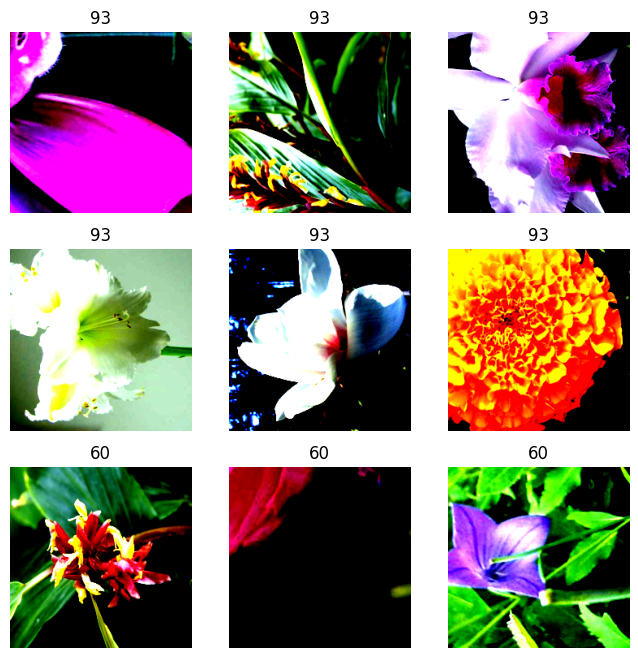

In [115]:
labels_map = {}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    if label not in labels_map:
      labels_map[label] = img
    figure.add_subplot(rows, cols, i)
    plt.title(list(labels_map.keys())[i % len(labels_map)]) #works when rerun
    plt.axis("off")
    plt.imshow(img.squeeze().T)
plt.show()

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


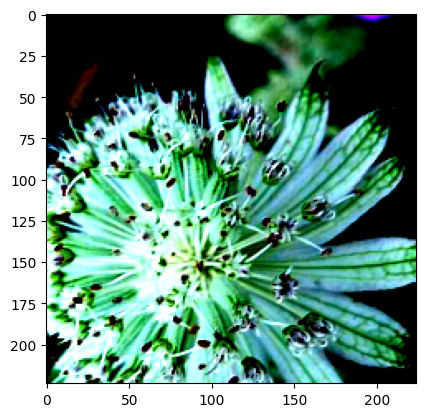

Label: 37


In [116]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].T.squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [117]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [123]:
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_pooling_stack = nn.Sequential(
            # Convolutional Layer
            nn.Conv2d(in_channels=3, out_channels=102, kernel_size=11, stride=4, padding=2),
            # Batch Normalization
            nn.BatchNorm2d(102),
            # Activation Layer
            nn.ReLU(inplace=True),
            # Pooling Layer
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(102, 256, kernel_size=5, padding=2),
            # Batch Normalization
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(384),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(384),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(384),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(384),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            # Fully connected layers
            nn.Linear(256 * 6 * 6, 4096),
            nn.LeakyReLU(inplace=True),
            # Regularization
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # Regularization
            nn.Dropout(),
            nn.Linear(4096, 102),
        )

    def forward(self, x):
        x = self.conv_pooling_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [124]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv_pooling_stack): Sequential(
    (0): Conv2d(3, 102, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(102, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [125]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (conv_pooling_stack): Sequential(
    (0): Conv2d(3, 102, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(102, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_run

In [126]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        correct += (pred.argmax(1) == y).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_accuracy = 100.0 * correct / size
    print(f"Training Accuracy: {train_accuracy:.2f}%\n")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).sum().item()

    test_loss /= size
    test_accuracy = 100.0 * correct / size
    print(f"Validation Error: \n Accuracy: {test_accuracy:>0.2f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Training loss: 4.672888  [   64/ 1020]
Training Accuracy: 0.39%

Validation Error: 
 Accuracy: 1.15%, Avg loss: 0.072964 

Epoch 2
-------------------------------
Training loss: 4.639905  [   64/ 1020]
Training Accuracy: 1.18%

Validation Error: 
 Accuracy: 1.46%, Avg loss: 0.072962 

Epoch 3
-------------------------------
Training loss: 4.650959  [   64/ 1020]
Training Accuracy: 0.78%

Validation Error: 
 Accuracy: 1.69%, Avg loss: 0.072892 

Epoch 4
-------------------------------
Training loss: 4.608071  [   64/ 1020]
Training Accuracy: 0.69%

Validation Error: 
 Accuracy: 2.00%, Avg loss: 0.072830 

Epoch 5
-------------------------------
Training loss: 4.601291  [   64/ 1020]
Training Accuracy: 1.76%

Validation Error: 
 Accuracy: 1.97%, Avg loss: 0.072757 

Epoch 6
-------------------------------
Training loss: 4.641654  [   64/ 1020]
Training Accuracy: 1.08%

Validation Error: 
 Accuracy: 2.33%, Avg loss: 0.072704 

Epoch 7
--------------